# Part 1: Training Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

## Step 1.0 - Hold out Test Set (Create Validation Set)

In [2]:
target = "emotion_types"

In [3]:
df_iad = pd.read_csv("../data/classification/final_iadsed.csv")
df_emo = pd.read_csv("../data/classification/final_emosounds.csv")

In [4]:
"""
  Load target feature on y and drop target feature on X.
  Encode the target labels. Scale features for SVM.
  Perform shuffle on first split to prevent bias. Split 80-20 for train-test.
  Split again on train to get validation set. So 60-20-20.
"""
def train_test_valid_split(df, target):
  le = LabelEncoder()
  y = le.fit_transform(df[target])
  X = df.drop(target, axis=1)

  scaler = StandardScaler()
  X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.20, random_state=101, shuffle=True)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=101)

  return X_train, X_test, X_val, y_train, y_test, y_val, le, scaler

Perform the splits for train, test, and validation sets.

In [5]:
X_train_iad, X_test_iad, X_val_iad, y_train_iad, y_test_iad, y_val_iad, le_iad, scaler_iad = train_test_valid_split(df_iad, target)

In [6]:
X_train_emo, X_test_emo, X_val_emo, y_train_emo, y_test_emo, y_val_emo, le_emo, scaler_emo = train_test_valid_split(df_emo, target)

SVM Classification Model (RBF Kernel)

In [7]:
"""
  Creates and trains an SVM classifier with RBF kernel.
  If search=True, performs GridSearchCV over param_grid with 5-fold CV.
  If feature_select=True, applies SelectKBest before training.
  Returns the trained model.
"""
def SVMClassifier(X_train, y_train, C=1.0, gamma='scale', search=False, param_grid=None, feature_select=False, top_k=20):

  if search and param_grid is not None:
    svm = SVC(kernel='rbf', random_state=101)
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, refit=True)
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Macro F1 (CV): {grid_search.best_score_:.4f}")

    return grid_search.best_estimator_, grid_search.best_params_

  if feature_select:
    selector = SelectKBest(score_func=f_classif, k=top_k)
    X_train_selected = selector.fit_transform(X_train, y_train)

    svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=101)
    svm.fit(X_train_selected, y_train)

    return svm, selector

  svm = SVC(kernel='rbf', C=C, gamma=gamma, random_state=101)
  svm.fit(X_train, y_train)

  return svm, None

In [8]:
"""
  Evaluates the SVM model on a given set.
  Returns accuracy and macro F1 score.
"""
def SVMPredictions(model, X_test, y_test, ds_type, ds_name, le, selector=None):
  if selector is not None:
    X_test = selector.transform(X_test)

  predictions = model.predict(X_test)

  acc = accuracy_score(y_test, predictions)
  f1 = f1_score(y_test, predictions, average='macro')

  print(f'{ds_name} - {ds_type} Accuracy: {acc:.4f}')
  print(f'{ds_name} - {ds_type} Macro F1: {f1:.4f}')

  return acc, f1

Train the SVM model on the datasets with default parameters (C=1.0, gamma='scale').

In [9]:
svm_iad, _ = SVMClassifier(X_train=X_train_iad, y_train=y_train_iad)

In [10]:
svm_emo, _ = SVMClassifier(X_train=X_train_emo, y_train=y_train_emo)

Make the predictions with validation set first and then test set to compare metrics.

In [11]:
SVMPredictions(model=svm_iad, X_test=X_val_iad, y_test=y_val_iad, ds_type="Validation", ds_name="IADSED", le=le_iad)

SVMPredictions(model=svm_iad, X_test=X_test_iad, y_test=y_test_iad, ds_type="Test", ds_name="IADSED", le=le_iad)

IADSED - Validation Accuracy: 0.7315
IADSED - Validation Macro F1: 0.6543
IADSED - Test Accuracy: 0.7151
IADSED - Test Macro F1: 0.5779


(0.7150537634408602, 0.5778862245410732)

In [12]:
SVMPredictions(model=svm_emo, X_test=X_val_emo, y_test=y_val_emo, ds_type="Validation", ds_name="EmoSounds", le=le_emo)

SVMPredictions(model=svm_emo, X_test=X_test_emo, y_test=y_test_emo, ds_type="Test", ds_name="EmoSounds", le=le_emo)

EmoSounds - Validation Accuracy: 0.6875
EmoSounds - Validation Macro F1: 0.4468
EmoSounds - Test Accuracy: 0.7083
EmoSounds - Test Macro F1: 0.4871


(0.7083333333333334, 0.4871001031991744)

## Steps 1.1 and 1.2 - 5-Fold Cross-Validation & Hyperparameter Tuning

In [13]:
"""
  Merges training and validation data, since we are now performing K-Fold CV.
"""
def concat_train_valid(X_train, y_train, X_val, y_val):
  X_train = pd.concat([X_train, X_val])
  y_train = np.concatenate([y_train, y_val])

  return X_train, y_train

Merge the training and validation data for both datasets.

In [14]:
X_train_iad, y_train_iad = concat_train_valid(X_train_iad, y_train_iad, X_val_iad, y_val_iad)

In [15]:
X_train_emo, y_train_emo = concat_train_valid(X_train_emo, y_train_emo, X_val_emo, y_val_emo)

Hyperparameter Grid Setup for GridSearchCV

In [16]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

Search to find the best hyperparameters

In [17]:
svm_cv_iad, best_params_iad = SVMClassifier(X_train=X_train_iad, y_train=y_train_iad,
                                             search=True, param_grid=param_grid)

Best Parameters: {'C': 10, 'gamma': 0.01}
Best Macro F1 (CV): 0.6588


In [18]:
svm_cv_emo, best_params_emo = SVMClassifier(X_train=X_train_emo, y_train=y_train_emo,
                                             search=True, param_grid=param_grid)

Best Parameters: {'C': 10, 'gamma': 0.01}
Best Macro F1 (CV): 0.5496


# Step 1.3 - Retrain model with best hyperparameters.

GridSearchCV already retrains with the best parameters (refit=True), so `svm_cv_iad` and `svm_cv_emo` are already the best models.

# Step 1.4 - Evaluate again with test set

In [19]:
acc_iad_imb, f1_iad_imb = SVMPredictions(model=svm_cv_iad, X_test=X_test_iad, y_test=y_test_iad, ds_type="Test", ds_name="IADSED", le=le_iad)

IADSED - Test Accuracy: 0.6989
IADSED - Test Macro F1: 0.6119


In [20]:
acc_emo_imb, f1_emo_imb = SVMPredictions(model=svm_cv_emo, X_test=X_test_emo, y_test=y_test_emo, ds_type="Test", ds_name="EmoSounds", le=le_emo)

EmoSounds - Test Accuracy: 0.6417
EmoSounds - Test Macro F1: 0.4523


# Part 2: Training with Feature Selection

In [21]:
df_iad_fs = pd.read_csv("../data/classification/final_iadsed.csv")
df_emo_fs = pd.read_csv("../data/classification/final_emosounds.csv")

## Step 2.0 - Hold out Test Set (Create Validation Set)

In [22]:
X_train_iad_fs, X_test_iad_fs, X_val_iad_fs, y_train_iad_fs, y_test_iad_fs, y_val_iad_fs, le_iad_fs, scaler_iad_fs = train_test_valid_split(df_iad_fs, target)

X_train_emo_fs, X_test_emo_fs, X_val_emo_fs, y_train_emo_fs, y_test_emo_fs, y_val_emo_fs, le_emo_fs, scaler_emo_fs = train_test_valid_split(df_emo_fs, target)

Run SelectKBest (f_classif) with top 20 features selected.

In [23]:
svm_iad_fs, skb_iad = SVMClassifier(X_train=X_train_iad_fs, y_train=y_train_iad_fs, feature_select=True, top_k=20)

svm_emo_fs, skb_emo = SVMClassifier(X_train=X_train_emo_fs, y_train=y_train_emo_fs, feature_select=True, top_k=20)

/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [24]:
SVMPredictions(model=svm_iad_fs, X_test=X_val_iad_fs, y_test=y_val_iad_fs, ds_type="Validation", ds_name="IADSED", le=le_iad_fs, selector=skb_iad)

SVMPredictions(model=svm_iad_fs, X_test=X_test_iad_fs, y_test=y_test_iad_fs, ds_type="Test", ds_name="IADSED", le=le_iad_fs, selector=skb_iad)

IADSED - Validation Accuracy: 0.7315
IADSED - Validation Macro F1: 0.6698
IADSED - Test Accuracy: 0.6989
IADSED - Test Macro F1: 0.5644


(0.6989247311827957, 0.5644074161028264)

In [25]:
SVMPredictions(model=svm_emo_fs, X_test=X_val_emo_fs, y_test=y_val_emo_fs, ds_type="Validation", ds_name="EmoSounds", le=le_emo_fs, selector=skb_emo)

SVMPredictions(model=svm_emo_fs, X_test=X_test_emo_fs, y_test=y_test_emo_fs, ds_type="Test", ds_name="EmoSounds", le=le_emo_fs, selector=skb_emo)

EmoSounds - Validation Accuracy: 0.7083
EmoSounds - Validation Macro F1: 0.4898
EmoSounds - Test Accuracy: 0.7167
EmoSounds - Test Macro F1: 0.5260


(0.7166666666666667, 0.5259540375289901)

## Steps 2.1 and 2.2 - 5-Fold Cross-Validation & Hyperparameter Tuning

In [26]:
X_train_iad_fs, y_train_iad_fs = concat_train_valid(X_train_iad_fs, y_train_iad_fs, X_val_iad_fs, y_val_iad_fs)

X_train_emo_fs, y_train_emo_fs = concat_train_valid(X_train_emo_fs, y_train_emo_fs, X_val_emo_fs, y_val_emo_fs)

In [27]:
# Apply SelectKBest to the merged training data and then do GridSearchCV on selected features
skb_iad_cv = SelectKBest(score_func=f_classif, k=20)
X_train_iad_fs_sel = skb_iad_cv.fit_transform(X_train_iad_fs, y_train_iad_fs)

skb_emo_cv = SelectKBest(score_func=f_classif, k=20)
X_train_emo_fs_sel = skb_emo_cv.fit_transform(X_train_emo_fs, y_train_emo_fs)

/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [28]:
svm_cv_iad_fs, best_params_iad_fs = SVMClassifier(X_train=X_train_iad_fs_sel, y_train=y_train_iad_fs,
                                                   search=True, param_grid=param_grid)

Best Parameters: {'C': 100, 'gamma': 0.01}
Best Macro F1 (CV): 0.6800


In [29]:
svm_cv_emo_fs, best_params_emo_fs = SVMClassifier(X_train=X_train_emo_fs_sel, y_train=y_train_emo_fs,
                                                   search=True, param_grid=param_grid)

Best Parameters: {'C': 100, 'gamma': 0.01}
Best Macro F1 (CV): 0.6102


# Step 2.3 - Retrain model with best hyperparameters.

GridSearchCV already retrains with the best parameters (refit=True).

# Step 2.4 - Evaluate again with test set.

In [30]:
X_test_iad_fs_sel = skb_iad_cv.transform(X_test_iad_fs)
acc_iad_imb_fs, f1_iad_imb_fs = SVMPredictions(model=svm_cv_iad_fs, X_test=X_test_iad_fs_sel, y_test=y_test_iad_fs, ds_type="Test", ds_name="IADSED", le=le_iad_fs)

IADSED - Test Accuracy: 0.7043
IADSED - Test Macro F1: 0.6107


In [31]:
X_test_emo_fs_sel = skb_emo_cv.transform(X_test_emo_fs)
acc_emo_imb_fs, f1_emo_imb_fs = SVMPredictions(model=svm_cv_emo_fs, X_test=X_test_emo_fs_sel, y_test=y_test_emo_fs, ds_type="Test", ds_name="EmoSounds", le=le_emo_fs)

EmoSounds - Test Accuracy: 0.6333
EmoSounds - Test Macro F1: 0.4911


# Part 3: Training with Balanced Dataset (SMOTE)

In [32]:
df_iad_bal = pd.read_csv("../data/classification/final_iadsed.csv")
df_emo_bal = pd.read_csv("../data/classification/final_emosounds.csv")

## Step 3.0 - Hold out Test Set (Create Validation Set)

In [33]:
X_train_iad_bal, X_test_iad_bal, X_val_iad_bal, y_train_iad_bal, y_test_iad_bal, y_val_iad_bal, le_iad_bal, scaler_iad_bal = train_test_valid_split(df_iad_bal, target)

X_train_emo_bal, X_test_emo_bal, X_val_emo_bal, y_train_emo_bal, y_test_emo_bal, y_val_emo_bal, le_emo_bal, scaler_emo_bal = train_test_valid_split(df_emo_bal, target)

Apply SMOTE to balance the training data only (not test/validation).

In [34]:
smote = SMOTE(random_state=101)

X_train_iad_bal, y_train_iad_bal = smote.fit_resample(X_train_iad_bal, y_train_iad_bal)
X_train_emo_bal, y_train_emo_bal = smote.fit_resample(X_train_emo_bal, y_train_emo_bal)

print("IADSED balanced training class distribution:")
print(pd.Series(y_train_iad_bal).value_counts())
print("\nEmoSounds balanced training class distribution:")
print(pd.Series(y_train_emo_bal).value_counts())

IADSED balanced training class distribution:
1    313
2    313
0    313
3    313
Name: count, dtype: int64

EmoSounds balanced training class distribution:
1    141
3    141
2    141
0    141
Name: count, dtype: int64


Train SVM on balanced training data with default parameters.

In [35]:
svm_iad_bal, _ = SVMClassifier(X_train=X_train_iad_bal, y_train=y_train_iad_bal)
svm_emo_bal, _ = SVMClassifier(X_train=X_train_emo_bal, y_train=y_train_emo_bal)

In [36]:
SVMPredictions(model=svm_iad_bal, X_test=X_val_iad_bal, y_test=y_val_iad_bal, ds_type="Validation", ds_name="IADSED (Balanced)", le=le_iad_bal)

SVMPredictions(model=svm_iad_bal, X_test=X_test_iad_bal, y_test=y_test_iad_bal, ds_type="Test", ds_name="IADSED (Balanced)", le=le_iad_bal)

IADSED (Balanced) - Validation Accuracy: 0.7248
IADSED (Balanced) - Validation Macro F1: 0.6959
IADSED (Balanced) - Test Accuracy: 0.7204
IADSED (Balanced) - Test Macro F1: 0.6399


(0.7204301075268817, 0.6399224307637242)

In [37]:
SVMPredictions(model=svm_emo_bal, X_test=X_val_emo_bal, y_test=y_val_emo_bal, ds_type="Validation", ds_name="EmoSounds (Balanced)", le=le_emo_bal)

SVMPredictions(model=svm_emo_bal, X_test=X_test_emo_bal, y_test=y_test_emo_bal, ds_type="Test", ds_name="EmoSounds (Balanced)", le=le_emo_bal)

EmoSounds (Balanced) - Validation Accuracy: 0.6667
EmoSounds (Balanced) - Validation Macro F1: 0.5626
EmoSounds (Balanced) - Test Accuracy: 0.6500
EmoSounds (Balanced) - Test Macro F1: 0.5108


(0.65, 0.5108057170736733)

## Steps 3.1 and 3.2 - 5-Fold Cross-Validation & Hyperparameter Tuning (Balanced)

Merge validation into training (SMOTE already applied to train before val merge, so we apply SMOTE again after merge).

In [38]:
# Reload fresh splits for merging (since SMOTE was already applied to the training data above)
X_train_iad_bal2, X_test_iad_bal2, X_val_iad_bal2, y_train_iad_bal2, y_test_iad_bal2, y_val_iad_bal2, _, _ = train_test_valid_split(df_iad_bal, target)
X_train_emo_bal2, X_test_emo_bal2, X_val_emo_bal2, y_train_emo_bal2, y_test_emo_bal2, y_val_emo_bal2, _, _ = train_test_valid_split(df_emo_bal, target)

# Merge train + val
X_train_iad_bal2, y_train_iad_bal2 = concat_train_valid(X_train_iad_bal2, y_train_iad_bal2, X_val_iad_bal2, y_val_iad_bal2)
X_train_emo_bal2, y_train_emo_bal2 = concat_train_valid(X_train_emo_bal2, y_train_emo_bal2, X_val_emo_bal2, y_val_emo_bal2)

# Apply SMOTE to the merged train+val data
X_train_iad_bal2, y_train_iad_bal2 = smote.fit_resample(X_train_iad_bal2, y_train_iad_bal2)
X_train_emo_bal2, y_train_emo_bal2 = smote.fit_resample(X_train_emo_bal2, y_train_emo_bal2)

In [39]:
svm_cv_iad_bal, best_params_iad_bal = SVMClassifier(X_train=X_train_iad_bal2, y_train=y_train_iad_bal2,
                                                     search=True, param_grid=param_grid)

Best Parameters: {'C': 10, 'gamma': 0.1}
Best Macro F1 (CV): 0.9421


In [40]:
svm_cv_emo_bal, best_params_emo_bal = SVMClassifier(X_train=X_train_emo_bal2, y_train=y_train_emo_bal2,
                                                     search=True, param_grid=param_grid)

Best Parameters: {'C': 10, 'gamma': 'scale'}
Best Macro F1 (CV): 0.8466


# Step 3.3 - Evaluate with test set (Balanced, no feature selection)

In [41]:
acc_iad_bal, f1_iad_bal = SVMPredictions(model=svm_cv_iad_bal, X_test=X_test_iad_bal2, y_test=y_test_iad_bal2, ds_type="Test", ds_name="IADSED (Balanced)", le=le_iad_bal)

IADSED (Balanced) - Test Accuracy: 0.5699
IADSED (Balanced) - Test Macro F1: 0.2953


In [42]:
acc_emo_bal, f1_emo_bal = SVMPredictions(model=svm_cv_emo_bal, X_test=X_test_emo_bal2, y_test=y_test_emo_bal2, ds_type="Test", ds_name="EmoSounds (Balanced)", le=le_emo_bal)

EmoSounds (Balanced) - Test Accuracy: 0.6333
EmoSounds (Balanced) - Test Macro F1: 0.4434


## Steps 3.4 - Balanced + Feature Selection (SelectKBest)

In [43]:
# Apply SelectKBest on balanced training data
skb_iad_bal = SelectKBest(score_func=f_classif, k=20)
X_train_iad_bal_sel = skb_iad_bal.fit_transform(X_train_iad_bal2, y_train_iad_bal2)

skb_emo_bal = SelectKBest(score_func=f_classif, k=20)
X_train_emo_bal_sel = skb_emo_bal.fit_transform(X_train_emo_bal2, y_train_emo_bal2)

/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [0] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/Users/avinashduggal/CS 273/nlp-emotion-prediction/.venv/lib/python3.14/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [44]:
svm_cv_iad_bal_fs, best_params_iad_bal_fs = SVMClassifier(X_train=X_train_iad_bal_sel, y_train=y_train_iad_bal2,
                                                          search=True, param_grid=param_grid)

Best Parameters: {'C': 100, 'gamma': 0.1}
Best Macro F1 (CV): 0.9199


In [45]:
svm_cv_emo_bal_fs, best_params_emo_bal_fs = SVMClassifier(X_train=X_train_emo_bal_sel, y_train=y_train_emo_bal2,
                                                          search=True, param_grid=param_grid)

Best Parameters: {'C': 10, 'gamma': 0.1}
Best Macro F1 (CV): 0.8300


# Step 3.5 - Evaluate with test set (Balanced + Feature Selection)

In [46]:
X_test_iad_bal_sel = skb_iad_bal.transform(X_test_iad_bal2)
acc_iad_bal_fs, f1_iad_bal_fs = SVMPredictions(model=svm_cv_iad_bal_fs, X_test=X_test_iad_bal_sel, y_test=y_test_iad_bal2, ds_type="Test", ds_name="IADSED (Balanced + FS)", le=le_iad_bal)

IADSED (Balanced + FS) - Test Accuracy: 0.6505
IADSED (Balanced + FS) - Test Macro F1: 0.5702


In [47]:
X_test_emo_bal_sel = skb_emo_bal.transform(X_test_emo_bal2)
acc_emo_bal_fs, f1_emo_bal_fs = SVMPredictions(model=svm_cv_emo_bal_fs, X_test=X_test_emo_bal_sel, y_test=y_test_emo_bal2, ds_type="Test", ds_name="EmoSounds (Balanced + FS)", le=le_emo_bal)

EmoSounds (Balanced + FS) - Test Accuracy: 0.6250
EmoSounds (Balanced + FS) - Test Macro F1: 0.5087


# Part 4: Comparison of Results

In [48]:
results = pd.DataFrame({
    'Dataset': ['IADSED', 'IADSED', 'IADSED', 'IADSED',
                'EmoSounds', 'EmoSounds', 'EmoSounds', 'EmoSounds'],
    'Condition': ['Imbalanced', 'Imbalanced + SelectKBest', 'Balanced (SMOTE)', 'Balanced + SelectKBest',
                  'Imbalanced', 'Imbalanced + SelectKBest', 'Balanced (SMOTE)', 'Balanced + SelectKBest'],
    'Accuracy': [acc_iad_imb, acc_iad_imb_fs, acc_iad_bal, acc_iad_bal_fs,
                 acc_emo_imb, acc_emo_imb_fs, acc_emo_bal, acc_emo_bal_fs],
    'Macro F1': [f1_iad_imb, f1_iad_imb_fs, f1_iad_bal, f1_iad_bal_fs,
                 f1_emo_imb, f1_emo_imb_fs, f1_emo_bal, f1_emo_bal_fs]
})

results['Accuracy'] = results['Accuracy'].round(4)
results['Macro F1'] = results['Macro F1'].round(4)

print(results.to_string(index=False))

  Dataset                Condition  Accuracy  Macro F1
   IADSED               Imbalanced    0.6989    0.6119
   IADSED Imbalanced + SelectKBest    0.7043    0.6107
   IADSED         Balanced (SMOTE)    0.5699    0.2953
   IADSED   Balanced + SelectKBest    0.6505    0.5702
EmoSounds               Imbalanced    0.6417    0.4523
EmoSounds Imbalanced + SelectKBest    0.6333    0.4911
EmoSounds         Balanced (SMOTE)    0.6333    0.4434
EmoSounds   Balanced + SelectKBest    0.6250    0.5087


Confusion Matrix for the best model on each dataset. The best model is selected based on the highest Macro F1 score.

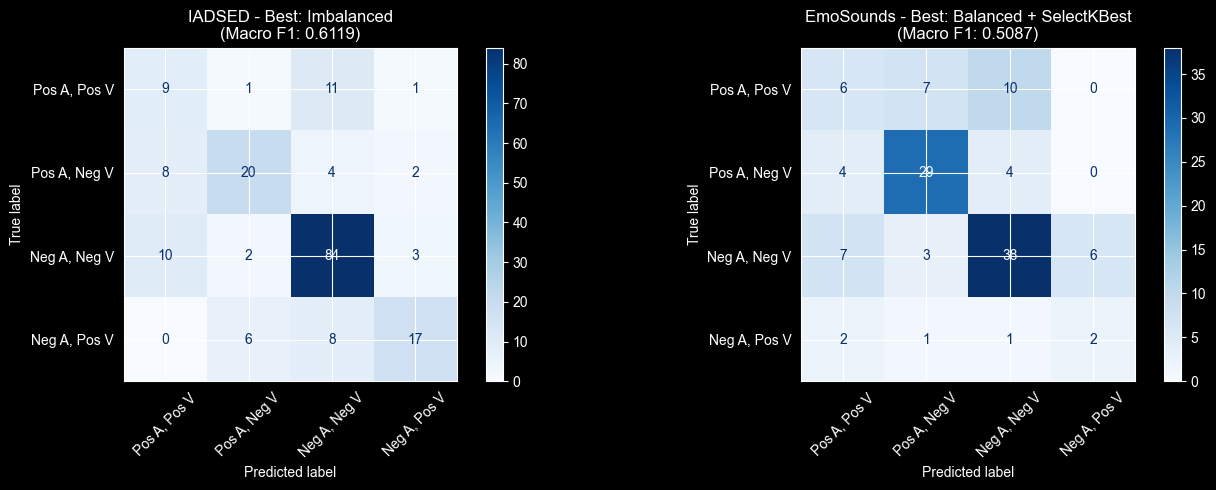

In [49]:
# Determine best model for each dataset based on Macro F1
iad_results = {
    'Imbalanced': (svm_cv_iad, X_test_iad, y_test_iad, f1_iad_imb, None),
    'Imbalanced + SelectKBest': (svm_cv_iad_fs, X_test_iad_fs_sel, y_test_iad_fs, f1_iad_imb_fs, None),
    'Balanced': (svm_cv_iad_bal, X_test_iad_bal2, y_test_iad_bal2, f1_iad_bal, None),
    'Balanced + SelectKBest': (svm_cv_iad_bal_fs, X_test_iad_bal_sel, y_test_iad_bal2, f1_iad_bal_fs, None),
}

emo_results = {
    'Imbalanced': (svm_cv_emo, X_test_emo, y_test_emo, f1_emo_imb, None),
    'Imbalanced + SelectKBest': (svm_cv_emo_fs, X_test_emo_fs_sel, y_test_emo_fs, f1_emo_imb_fs, None),
    'Balanced': (svm_cv_emo_bal, X_test_emo_bal2, y_test_emo_bal2, f1_emo_bal, None),
    'Balanced + SelectKBest': (svm_cv_emo_bal_fs, X_test_emo_bal_sel, y_test_emo_bal2, f1_emo_bal_fs, None),
}

best_iad_name = max(iad_results, key=lambda k: iad_results[k][3])
best_emo_name = max(emo_results, key=lambda k: emo_results[k][3])

best_iad_model, best_iad_X, best_iad_y, best_iad_f1, _ = iad_results[best_iad_name]
best_emo_model, best_emo_X, best_emo_y, best_emo_f1, _ = emo_results[best_emo_name]

class_names = ["Pos A, Pos V", "Pos A, Neg V", "Neg A, Neg V", "Neg A, Pos V"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# IADSED confusion matrix
cm_iad = confusion_matrix(best_iad_y, best_iad_model.predict(best_iad_X))
disp_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad, display_labels=class_names)
disp_iad.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title(f"IADSED - Best: {best_iad_name}\n(Macro F1: {best_iad_f1:.4f})")

# EmoSounds confusion matrix
cm_emo = confusion_matrix(best_emo_y, best_emo_model.predict(best_emo_X))
disp_emo = ConfusionMatrixDisplay(confusion_matrix=cm_emo, display_labels=class_names)
disp_emo.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title(f"EmoSounds - Best: {best_emo_name}\n(Macro F1: {best_emo_f1:.4f})")

plt.tight_layout()
plt.show()